## 🔄 Dataset Preparation & Splitting

The original TrashNet (or Kaggle Garbage Classification) dataset comes as a set of folders, one per class  
(`cardboard`, `glass`, `metal`, `paper`, `plastic`, `trash`).  

However, PyTorch’s `ImageFolder` expects the dataset to be structured as:

```text
data/
├── train/
│   ├── cardboard/
│   ├── glass/
│   ├── metal/
│   ├── paper/
│   ├── plastic/
│   └── trash/
├── val/
│   ├── cardboard/
│   ├── glass/
│   ├── ...
└── test/
    ├── cardboard/
    ├── glass/
    └── ...
```

### This script does the following:

1. **Define dataset paths**  
   - `DATASET_DIR` → where the raw dataset is located.  
   - `OUTPUT_DIR` → where we want our final `train/val/test` folders.  

2. **Create empty output folders**  
   For each split (`train`, `val`, `test`) and each class (e.g. `cardboard`),  
   it makes the corresponding folder if it doesn’t already exist.

3. **Filter valid images**  
   It only includes files with image extensions (`.jpg`, `.jpeg`, `.png`).  
   This avoids errors when non-image files or hidden system files exist.

4. **Split the dataset**  
   - Uses `train_test_split` from scikit-learn.  
   - 70% → Training  
   - 15% → Validation  
   - 15% → Test  

   This ensures we have separate sets for training, model tuning, and final evaluation.

5. **Copy files into new structure**  
   Each image is copied into the correct folder under `train`, `val`, or `test`.  
   We use `shutil.copy2` which preserves file metadata (timestamps).


In [1]:
import os, shutil
from sklearn.model_selection import train_test_split

# Paths
DATASET_DIR = "dataset-resized"  # adjust if needed
OUTPUT_DIR = "data"

# Make sure output dirs exist
for split in ["train", "val", "test"]:
    for cls in os.listdir(DATASET_DIR):
        os.makedirs(os.path.join(OUTPUT_DIR, split, cls), exist_ok=True)

# Only keep image extensions
IMG_EXTENSIONS = (".jpg", ".jpeg", ".png")

for cls in os.listdir(DATASET_DIR):
    cls_path = os.path.join(DATASET_DIR, cls)
    if not os.path.isdir(cls_path):
        continue  # skip non-folders

    images = [f for f in os.listdir(cls_path) if f.lower().endswith(IMG_EXTENSIONS)]

    # Split 70% train, 15% val, 15% test
    train, temp = train_test_split(images, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    for split, files in zip(["train","val","test"], [train,val,test]):
        for f in files:
            src = os.path.join(cls_path, f)
            dst = os.path.join(OUTPUT_DIR, split, cls, f)
            shutil.copy2(src, dst)  # copy2 preserves metadata

print("✅ Dataset prepared under 'data/train', 'data/val', 'data/test'")

✅ Dataset prepared under 'data/train', 'data/val', 'data/test'


## 📂 1. Dataset & Preprocessing

### We’ll use TrashNet (6 classes: cardboard, glass, metal, paper, plastic, trash/organic).
Steps:

1. Load dataset → train/validation/test split.

2. Resize (224×224).

3. Normalize (ImageNet mean/std).

4. Apply augmentations (flip, rotation, brightness).

In [2]:
# Setup
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Load dataset
train_data = torchvision.datasets.ImageFolder("data/train", transform=train_transform)
val_data   = torchvision.datasets.ImageFolder("data/val", transform=test_transform)
test_data  = torchvision.datasets.ImageFolder("data/test", transform=test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

classes = train_data.classes
print("Classes:", classes)

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## 🧠 2. Baseline CNN (from scratch)

### We start with a simple CNN classifier to establish baseline accuracy.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class WasteCNN(nn.Module):
    def __init__(self):
        super(WasteCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*56*56, 256)
        self.fc2 = nn.Linear(256, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*56*56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# Device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Using device:", device)
if device.type == "cuda":
    print("   GPU:", torch.cuda.get_device_name(0))

custom_model = WasteCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, epochs=10, print_every=50):
    for epoch in range(epochs):
        model.train()
        total, correct, running_loss = 0, 0, 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Feedback every N batches
            if (batch_idx + 1) % print_every == 0:
                batch_acc = 100 * predicted.eq(labels).sum().item() / labels.size(0)
                print(f"Epoch [{epoch+1}/{epochs}] "
                      f"Batch [{batch_idx+1}/{len(train_loader)}] "
                      f"Loss: {loss.item():.4f} | Batch Acc: {batch_acc:.2f}%")

        epoch_acc = 100 * correct / total
        avg_loss = running_loss / len(train_loader)
        print(f"✅ Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Train Acc: {epoch_acc:.2f}%")

train_model(custom_model, train_loader, val_loader, epochs=10)

🚀 Using device: cuda
   GPU: NVIDIA GeForce RTX 3060
Epoch [1/10] Batch [50/56] Loss: 1.8196 | Batch Acc: 15.62%
✅ Epoch 1/10 | Avg Loss: 2.9828 | Train Acc: 24.75%
Epoch [2/10] Batch [50/56] Loss: 1.5726 | Batch Acc: 40.62%
✅ Epoch 2/10 | Avg Loss: 1.6211 | Train Acc: 32.33%
Epoch [3/10] Batch [50/56] Loss: 1.6151 | Batch Acc: 25.00%
✅ Epoch 3/10 | Avg Loss: 1.5518 | Train Acc: 35.96%
Epoch [4/10] Batch [50/56] Loss: 1.2248 | Batch Acc: 56.25%
✅ Epoch 4/10 | Avg Loss: 1.4131 | Train Acc: 43.94%
Epoch [5/10] Batch [50/56] Loss: 1.2206 | Batch Acc: 46.88%
✅ Epoch 5/10 | Avg Loss: 1.3018 | Train Acc: 50.28%
Epoch [6/10] Batch [50/56] Loss: 1.5157 | Batch Acc: 46.88%
✅ Epoch 6/10 | Avg Loss: 1.2294 | Train Acc: 54.42%
Epoch [7/10] Batch [50/56] Loss: 1.1723 | Batch Acc: 65.62%
✅ Epoch 7/10 | Avg Loss: 1.1673 | Train Acc: 56.40%
Epoch [8/10] Batch [50/56] Loss: 1.2658 | Batch Acc: 43.75%
✅ Epoch 8/10 | Avg Loss: 1.0723 | Train Acc: 60.19%
Epoch [9/10] Batch [50/56] Loss: 1.2375 | Batch Acc

## ⚡ 3. Transfer Learning with Pretrained Models

### Try VGG16, ResNet18, EfficientNet and compare.

In [6]:
from torchvision import models
from torchvision.models import ResNet18_Weights, VGG16_Weights, EfficientNet_B0_Weights

def get_model(model_name="resnet18"):
    if model_name == "resnet18":
        model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, len(classes))
    elif model_name == "vgg16":
        model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        model.classifier[6] = nn.Linear(4096, len(classes))
    elif model_name == "efficientnet":
        model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes))
    return model.to(device)

In [7]:
resnet18 = get_model("resnet18")
train_model(resnet18, train_loader, val_loader, epochs=10, print_every=20)

vgg16 = get_model("resnet18")
train_model(vgg16, train_loader, val_loader, epochs=10, print_every=20)

efficientnet = get_model("resnet18")
train_model(efficientnet, train_loader, val_loader, epochs=10, print_every=20)

Epoch [1/10] Batch [20/56] Loss: 1.6986 | Batch Acc: 21.88%
Epoch [1/10] Batch [40/56] Loss: 1.9211 | Batch Acc: 21.88%
✅ Epoch 1/10 | Avg Loss: 1.9181 | Train Acc: 17.27%
Epoch [2/10] Batch [20/56] Loss: 1.9179 | Batch Acc: 21.88%
Epoch [2/10] Batch [40/56] Loss: 1.8758 | Batch Acc: 18.75%
✅ Epoch 2/10 | Avg Loss: 1.9215 | Train Acc: 18.01%
Epoch [3/10] Batch [20/56] Loss: 1.8271 | Batch Acc: 21.88%
Epoch [3/10] Batch [40/56] Loss: 2.0216 | Batch Acc: 9.38%
✅ Epoch 3/10 | Avg Loss: 1.9259 | Train Acc: 17.67%
Epoch [4/10] Batch [20/56] Loss: 1.9325 | Batch Acc: 15.62%
Epoch [4/10] Batch [40/56] Loss: 1.7556 | Batch Acc: 28.12%
✅ Epoch 4/10 | Avg Loss: 1.9206 | Train Acc: 17.72%
Epoch [5/10] Batch [20/56] Loss: 1.8874 | Batch Acc: 18.75%
Epoch [5/10] Batch [40/56] Loss: 1.9721 | Batch Acc: 12.50%
✅ Epoch 5/10 | Avg Loss: 1.9267 | Train Acc: 18.01%
Epoch [6/10] Batch [20/56] Loss: 1.9773 | Batch Acc: 12.50%
Epoch [6/10] Batch [40/56] Loss: 1.8603 | Batch Acc: 15.62%
✅ Epoch 6/10 | Avg Lo

## 📊 4. Evaluation Metrics

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate(model, loader):
    model.eval()
    preds, labels_all = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            preds.extend(predicted.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    print(classification_report(labels_all, preds, target_names=classes, zero_division=0))
    cm = confusion_matrix(labels_all, preds)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
    plt.show()

Custom Model
📊 Validation Set Results
              precision    recall  f1-score   support

   cardboard       0.76      0.65      0.70        60
       glass       0.43      0.51      0.46        75
       metal       0.32      0.25      0.28        61
       paper       0.63      0.78      0.69        89
     plastic       0.48      0.35      0.40        72
       trash       0.48      0.67      0.56        21

    accuracy                           0.53       378
   macro avg       0.52      0.53      0.52       378
weighted avg       0.52      0.53      0.52       378



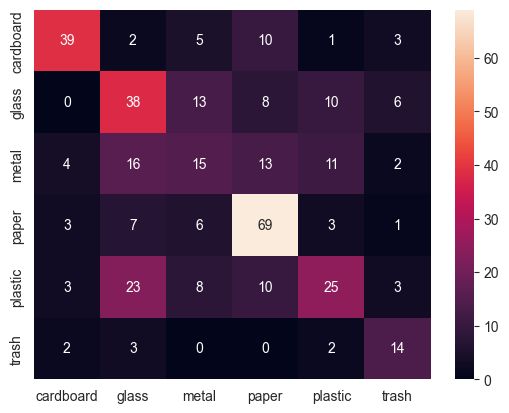

📊 Test Set Results
              precision    recall  f1-score   support

   cardboard       0.74      0.70      0.72        61
       glass       0.33      0.33      0.33        76
       metal       0.32      0.31      0.31        62
       paper       0.54      0.66      0.59        90
     plastic       0.46      0.34      0.39        73
       trash       0.42      0.52      0.47        21

    accuracy                           0.48       383
   macro avg       0.47      0.48      0.47       383
weighted avg       0.47      0.48      0.47       383



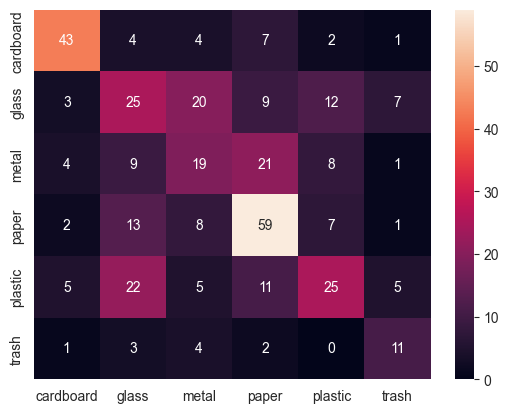

Res Net 18 Model
📊 Validation Set Results
              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        60
       glass       0.22      0.03      0.05        75
       metal       0.23      0.39      0.29        61
       paper       0.15      0.07      0.09        89
     plastic       0.18      0.54      0.27        72
       trash       0.00      0.00      0.00        21

    accuracy                           0.19       378
   macro avg       0.13      0.17      0.12       378
weighted avg       0.15      0.19      0.13       378



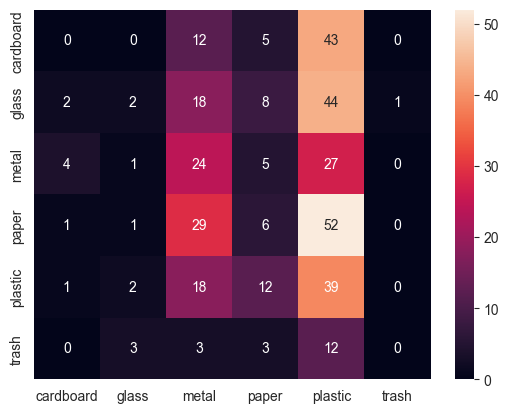

📊 Test Set Results
              precision    recall  f1-score   support

   cardboard       0.11      0.02      0.03        61
       glass       0.11      0.01      0.02        76
       metal       0.23      0.35      0.28        62
       paper       0.18      0.10      0.13        90
     plastic       0.19      0.56      0.28        73
       trash       0.00      0.00      0.00        21

    accuracy                           0.19       383
   macro avg       0.14      0.17      0.12       383
weighted avg       0.16      0.19      0.14       383



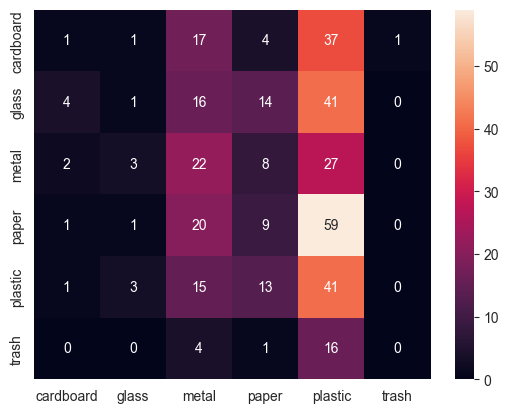

VGG 16 Model
📊 Validation Set Results
              precision    recall  f1-score   support

   cardboard       0.16      0.08      0.11        60
       glass       0.25      0.07      0.11        75
       metal       0.23      0.48      0.31        61
       paper       0.45      0.17      0.25        89
     plastic       0.24      0.54      0.33        72
       trash       0.00      0.00      0.00        21

    accuracy                           0.25       378
   macro avg       0.22      0.22      0.18       378
weighted avg       0.26      0.25      0.21       378



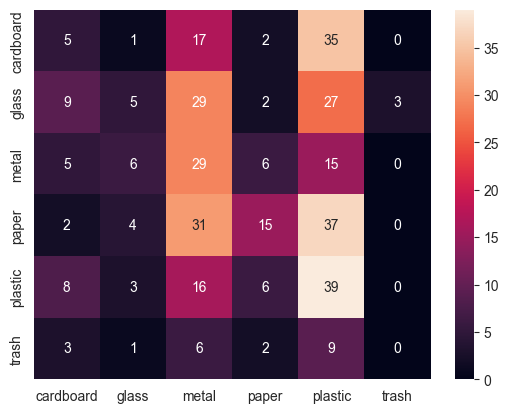

📊 Test Set Results
              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        61
       glass       0.39      0.09      0.15        76
       metal       0.16      0.35      0.22        62
       paper       0.36      0.10      0.16        90
     plastic       0.20      0.48      0.28        73
       trash       0.60      0.14      0.23        21

    accuracy                           0.20       383
   macro avg       0.28      0.19      0.17       383
weighted avg       0.26      0.20      0.17       383



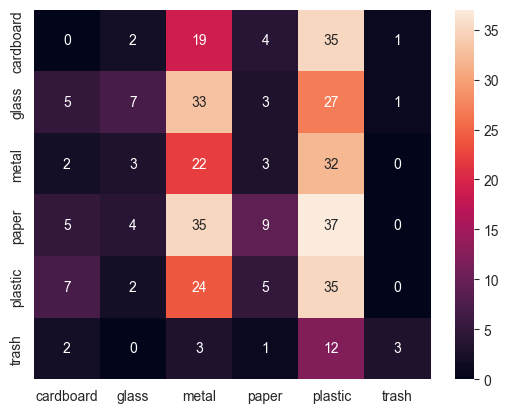

Efficient Net Model
📊 Validation Set Results
              precision    recall  f1-score   support

   cardboard       0.05      0.02      0.03        60
       glass       0.00      0.00      0.00        75
       metal       0.00      0.00      0.00        61
       paper       0.08      0.02      0.04        89
     plastic       0.00      0.00      0.00        72
       trash       0.06      0.86      0.10        21

    accuracy                           0.06       378
   macro avg       0.03      0.15      0.03       378
weighted avg       0.03      0.06      0.02       378



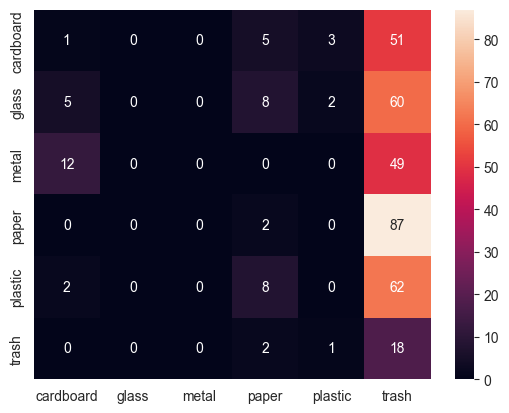

📊 Test Set Results
              precision    recall  f1-score   support

   cardboard       0.14      0.05      0.07        61
       glass       0.00      0.00      0.00        76
       metal       1.00      0.02      0.03        62
       paper       0.00      0.00      0.00        90
     plastic       0.14      0.01      0.03        73
       trash       0.06      0.95      0.11        21

    accuracy                           0.07       383
   macro avg       0.22      0.17      0.04       383
weighted avg       0.22      0.07      0.03       383



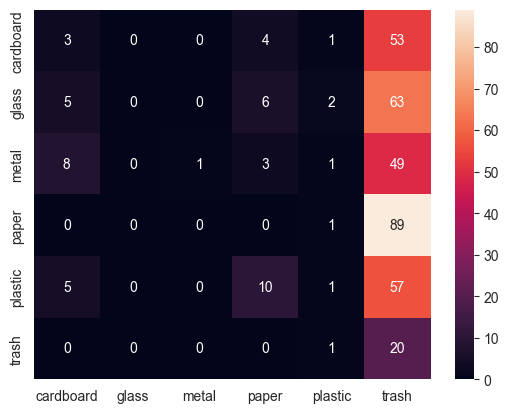

In [10]:

print("Custom Model")
print("📊 Validation Set Results")
evaluate(custom_model, val_loader)
print("📊 Test Set Results")
evaluate(custom_model, test_loader)

print("Res Net 18 Model")
print("📊 Validation Set Results")
evaluate(resnet18, val_loader)
print("📊 Test Set Results")
evaluate(resnet18, test_loader)

print("VGG 16 Model")
print("📊 Validation Set Results")
evaluate(vgg16, val_loader)
print("📊 Test Set Results")
evaluate(vgg16, test_loader)

print("Efficient Net Model")
print("📊 Validation Set Results")
evaluate(efficientnet, val_loader)
print("📊 Test Set Results")
evaluate(efficientnet, test_loader)